# Week 14 - Plan of attack!

- Plot PC's over bumpdir to see if PC's which are consistent for passive trials are still consistent.
- Find the active component within passive trials and have that stored somewhere.
- Input-Null components should have a low r2 during passive movement onsets, and higher during/before active movement onsets
- Input-Potent components should have higher r2 during all movement, regardless of intention.
- Have a graph that shows r2 for passive MO, activeMO during apssive trials and active MO.
- Maybe also show the r2 vs. temporal shift in position relative to signal.

In [1]:
from df_processing import setup_df
from df_decoding import predict_2d
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
main_df,firing_rates_per_session, positions_per_session, velocities_per_session, projections_per_session = setup_df(
                            prior=5,
                            post=500,
                            bin_size=0.01,
                            removal_threshold=5,
                            movement_onset_treshold=25,
                            maximum_duration_in_bins=500,
                            n_components=30,
                            debug=True)

Creating base...
Deleting NaNs...
Removing trials which take longer than 500ms ...
Square root Stabilizing spiking rates...
Centering session positions...
Calculating acceleration...
Determining movement onset...
Removing low firing neural below 5Hz...
Updating bin size to 0.01...
Calculating firing rate...
Calculating firing rates in window from movement onset to 500ms...
Calculating positions in window from movement onset to 500ms...
Session 0 has a total number of trials of: 638.
Session 1 has a total number of trials of: 1388.
Session 2 has a total number of trials of: 805.
Session 3 has a total number of trials of: 1034.
Calculating velocity in window from movement onset to 500ms...
Calculating 30 PC's.
Done!


In [3]:
active_df = main_df[(np.isnan(main_df['bumpDir'])) & (main_df['result'] == 'R') & (main_df['monkey'] == 'H')]
passive_df = main_df[~(np.isnan(main_df['bumpDir'])) & (main_df['result'] == 'R') & (main_df['monkey'] == 'H')]

In [4]:
print(len(active_df))
print(len(passive_df))
print(active_df.columns)

499
437
Index(['trialID', 'monkey', 'task', 'date_time', 'original_bin_size', 'result',
       'bumpDir', 'tgtDir', 'ctrHoldBump', 'ctrHold', 'idx_startTime',
       'idx_endTime', 'idx_bumpTime', 'idx_goCueTime', 'idx_tgtOnTime', 'pos',
       'vel', 'force', 'markers', 'joint_ang', 'joint_vel', 'muscle_len',
       'muscle_vel', 'S1_spikes', 'session', 'bin_size', 'trial_duration',
       'S1_spikes_old', 'acc', 'idx_movementOnset', 'idx_activeMovementOnset',
       'post', 'prior', 'firing_rates', 'firing_rates_window', 'pos_window',
       'active_pos_window', 'vel_window', 'PCA_window_from_full',
       'PCA_active_window_from_full'],
      dtype='object')


# Let's get the data

Necessary data:
- Decoding efficiency per Principal Component on Active trials.
- Decoding efficiency per Principal Component on Passive trials after Passive Movement Onset.
- Decoding efficiency per Principal Component on Passive trials after Active Movement Onset.

To do:
- Store active moment onset for passive trials.


In [5]:
def find_mvmt_onset(row_acc, center_index, threshold, span,rownum):
    #Start at center to avoid taking previous trial's acc.
    max_index = np.argmax(row_acc[int(center_index):int(center_index + span)]) + center_index
    max_value = row_acc[max_index]
    mvmt_onset_marker = max_index
    for i in range(max_index, center_index-2, -1):
        if row_acc[i] > (0.1*max_value):
            mvmt_onset_marker = i
        else:
            for j in range(threshold, 0, -1):
                if row_acc[i-j] > 0.7 * max_value:
                    i=j
                    break
            break
    return mvmt_onset_marker
    


def set_movement_onset(data_df, threshold):
    df = data_df.copy()
    threshold //= int((100*df.bin_size.loc[0]))
    df['idx_movementOnset'] = df.apply(lambda row: pd.NA if pd.isna(row['idx_goCueTime']) else find_mvmt_onset(row['acc'], int((row['idx_goCueTime']-row['idx_startTime'] if pd.isna(row['idx_bumpTime']) else row['idx_bumpTime']-row['idx_startTime'])), threshold, 100) + row['idx_startTime'], axis=1)
    return df

In [11]:
def get_active_mo_passive_trials(data_df, threshold):
    df = data_df.copy()
    threshold //= int((100*df.bin_size.loc[0]))
    df["idx_activeMovementOnset"] = df.apply(lambda row: 
                                             pd.NA if pd.isna(row['idx_bumpTime']) 
                                             else find_mvmt_onset(row['acc'], 
                                                                  int(row['idx_goCueTime']-row['idx_startTime']),
                                                                  threshold, 
                                                                  100,
                                                                  row['trialID']
                                                                  ) + 
                                            row['idx_startTime'], axis=1 )
    return df

In [12]:
test_df = main_df[main_df['result'] == 'R'].copy().reset_index(drop=True)
test_df = get_active_mo_passive_trials(test_df, 3)

In [13]:
active_df=test_df[(np.isnan(test_df['bumpDir'])) & (test_df['monkey'] == 'H')]
passive_df=test_df[(~np.isnan(test_df['bumpDir']))& (test_df['monkey'] == 'H')]

In [14]:
print(len(active_df))
print(len(passive_df))

499
437


Seems to be done.
Now, I need to add a new position/velocity window to the passive trials.

In [15]:
def df_relevant_position(data_df, prior, post):
    df = data_df.copy()
    session_positions = []
    all_positions = []
    all_active_positions = []
    for session in [0,1,2,3]:
        positions = df[df['session'] == session]['pos'].tolist()
        session_positions.append(np.concatenate(positions))
        session_position = session_positions[session]
        for i in df[df['session'] == session].index:
            if not pd.isna(df.at[i, 'idx_movementOnset']):
                start = int(df.at[i, 'idx_movementOnset'] - prior)
                stop = int(df.at[i, 'idx_movementOnset'] + post)
                all_positions.append(session_position[start: stop, ])
                
            else:
                all_positions.append(pd.NA)
        for i in df[df['session'] == session].index:
            if not pd.isna(df.at[i, 'idx_activeMovementOnset']):
                start = int(df.at[i, 'idx_activeMovementOnset'] - prior)
                stop = int(df.at[i, 'idx_activeMovementOnset'] + post)
                all_active_positions.append(session_position[start: stop, ])
            else:
                all_active_positions.append(pd.NA)
        
    df['pos_window'] = all_positions
    df['active_pos_window'] = all_active_positions
    return df, all_positions, all_active_positions

In [16]:
test_df,_,_ = df_relevant_position(test_df, 5, 150)

    

In [17]:
active_df=test_df[(np.isnan(test_df['bumpDir'])) & (test_df['monkey'] == 'H')]
passive_df=test_df[(~np.isnan(test_df['bumpDir']))& (test_df['monkey'] == 'H')]
print(len(active_df))
print(len(passive_df))

499
437


In [18]:
test = passive_df.iloc[108]

406 2


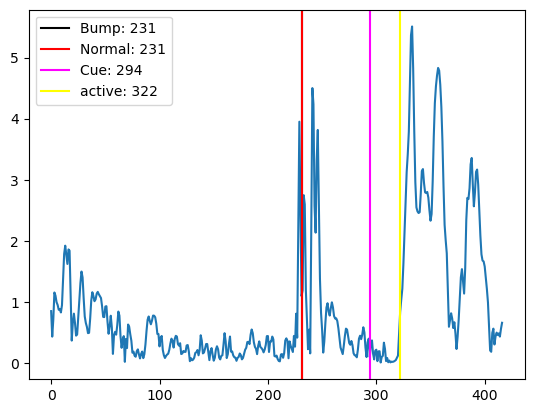

In [19]:
plt.plot(test.acc)
plt.axvline(int(test.idx_bumpTime-test.idx_startTime), color='black', label=f'Bump: {int(test.idx_bumpTime-test.idx_startTime)}')
plt.axvline((int(test.idx_movementOnset-test.idx_startTime)), color='red', label=f'Normal: {int(test.idx_movementOnset-test.idx_startTime)}')
plt.axvline((int(test.idx_goCueTime-test.idx_startTime)), color='magenta', label=f'Cue: {int(test.idx_goCueTime-test.idx_startTime)}')
plt.axvline((int(test.idx_activeMovementOnset-test.idx_startTime)), color='yellow', label=f'active: {int(test.idx_activeMovementOnset-test.idx_startTime)}')


plt.legend()
print(test.trialID, test.session)

505
505
Bumpdir: 270.0
Targetdir: 225.0


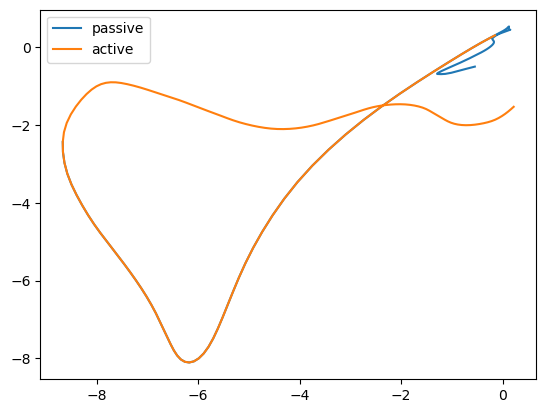

In [20]:
plt.plot(test['pos_window'][:150,0], test['pos_window'][:150, 1], label='passive')
print(len(test['pos_window'][:, 0]))
plt.plot(test['active_pos_window'][:150,0], test['active_pos_window'][:150, 1], label='active')
#plt.scatter(x=)
plt.legend()
print(len(test['active_pos_window'][:, 0]))
print(f'Bumpdir: {test.bumpDir}')
print(f'Targetdir: {test.tgtDir}')

# While the position seems weird, this makes sense because movement after target has been reached is arbitrary.

I can now start with getting the PCA window for this new active window.

### I've fixed this in the processing already. Relatively simple.

In [7]:
print(passive_df.columns)

Index(['trialID', 'monkey', 'task', 'date_time', 'original_bin_size', 'result',
       'bumpDir', 'tgtDir', 'ctrHoldBump', 'ctrHold', 'idx_startTime',
       'idx_endTime', 'idx_bumpTime', 'idx_goCueTime', 'idx_tgtOnTime', 'pos',
       'vel', 'force', 'markers', 'joint_ang', 'joint_vel', 'muscle_len',
       'muscle_vel', 'S1_spikes', 'session', 'bin_size', 'trial_duration',
       'S1_spikes_old', 'acc', 'idx_movementOnset', 'idx_activeMovementOnset',
       'post', 'prior', 'firing_rates', 'firing_rates_window', 'pos_window',
       'active_pos_window', 'vel_window', 'PCA_window_from_full',
       'PCA_active_window_from_full'],
      dtype='object')


In [8]:
print(len(passive_df))
print(len(main_df[main_df['session'] == 2]))
print(passive_df['pos_window'].iloc[400].shape)
print(passive_df['idx_movementOnset'].iloc[400])
print(passive_df['idx_activeMovementOnset'].iloc[400])
print(passive_df['PCA_window_from_full'].iloc[400].shape)

437
805
(505, 2)
231841
231908
(505, 30)


In [11]:
post = 15
time_offsets = [0,2,3,5,10,20]

offset_data = []
for time_offset in tqdm(time_offsets):
    all_active = []
    all_passive = []
    all_active_after_passive = []
    for i in tqdm(range(30)):
        all_active.append(
            predict_2d(
                    data_df=active_df,
                    iterations=50,
                    model=Ridge(),
                    prior=0,
                    post=post,
                    col_to_use='PCA_window_from_full', 
                    col_to_predict='pos_window',
                    cols_to_decode=[i],
                    time_offset=time_offset,
                    debug=False,
                    #sliding_window=15,
                    return_coef=False
                    )
        )
        all_passive.append(
            predict_2d(
                data_df=passive_df,
                model=Ridge(),
                iterations=50,
                prior=0,
                post=post,
                col_to_use='PCA_window_from_full', 
                col_to_predict='pos_window',
                cols_to_decode=[i],
                time_offset=time_offset,
            )
        )
        all_active_after_passive.append(
            predict_2d(
                data_df=passive_df,
                model=Ridge(),
                iterations=50,
                prior=0,
                post=post,
                col_to_use='PCA_active_window_from_full', 
                col_to_predict='active_pos_window',
                cols_to_decode=[i],
                time_offset=time_offset,
            )
        )
    offset_data.append([all_active,all_passive,all_active_after_passive])

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

3


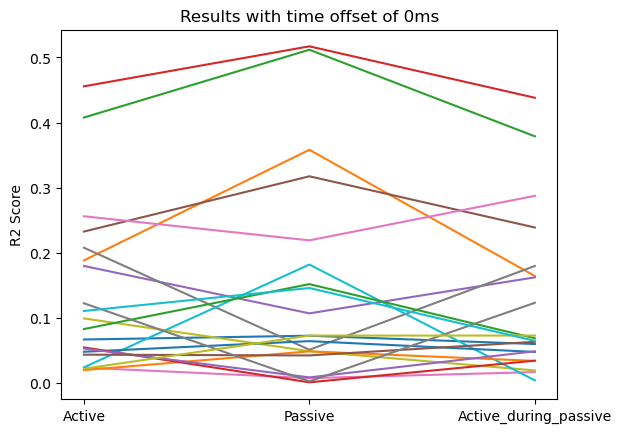

3


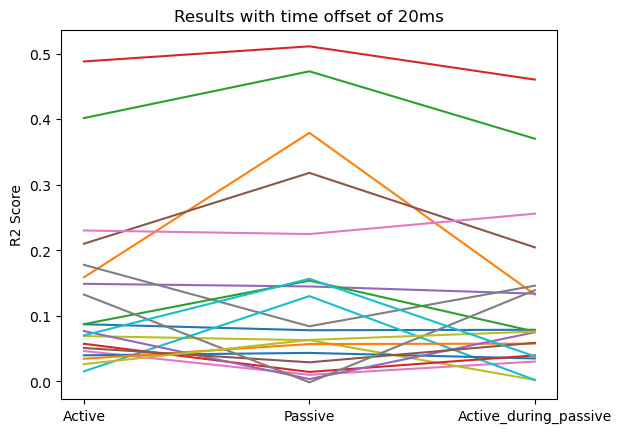

3


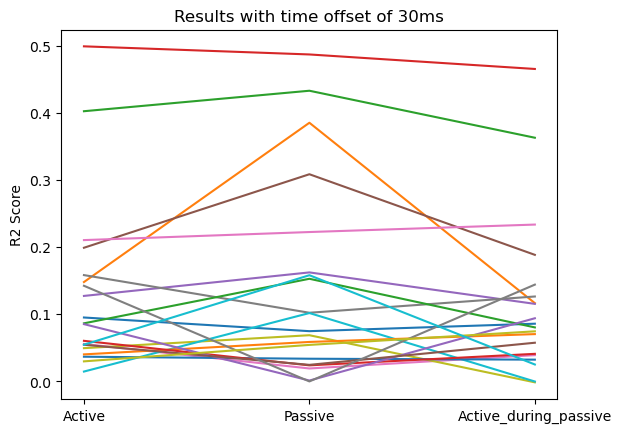

3


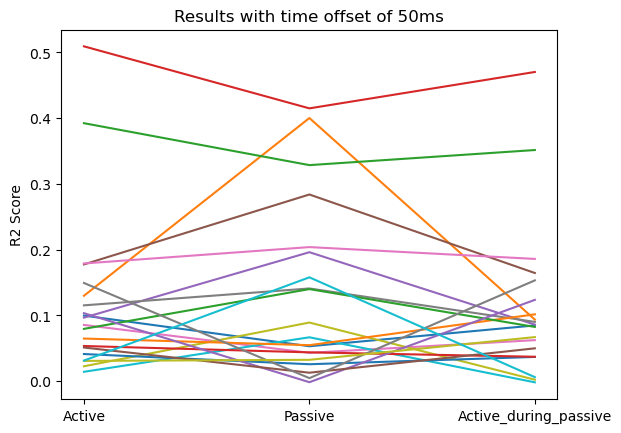

3


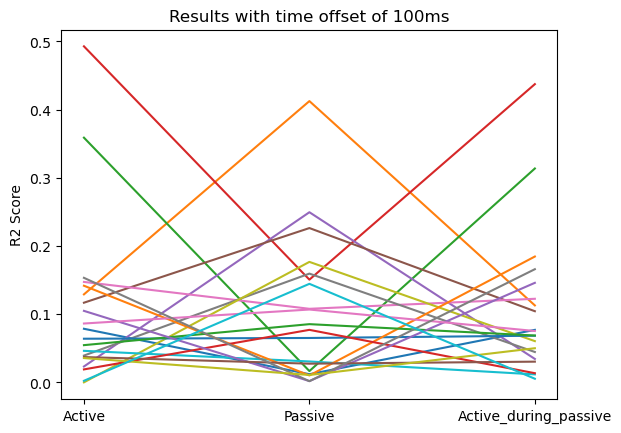

3


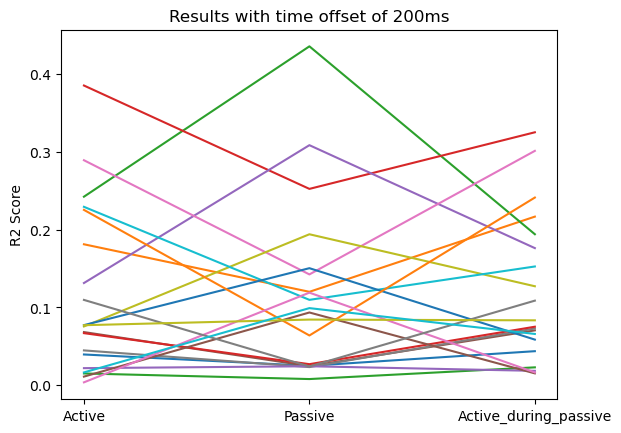

In [12]:
for i, time_offset in enumerate(time_offsets):
    print(len(offset_data[i]))
    for pc in range(20):
        y = [offset_data[i][0][pc][0][0], offset_data[i][1][pc][0][0], offset_data[i][2][pc][0][0]]
        plt.plot(y)
    plt.xticks([0,1,2], ['Active', 'Passive', 'Active_during_passive'])
    plt.ylabel('R2 Score')
    plt.title(f"Results with time offset of {time_offset*10}ms")
    plt.show()


# YES!

Finally something that looks like it did before. Now, to isolate some of the PC's, let's have a look at them all seperately.

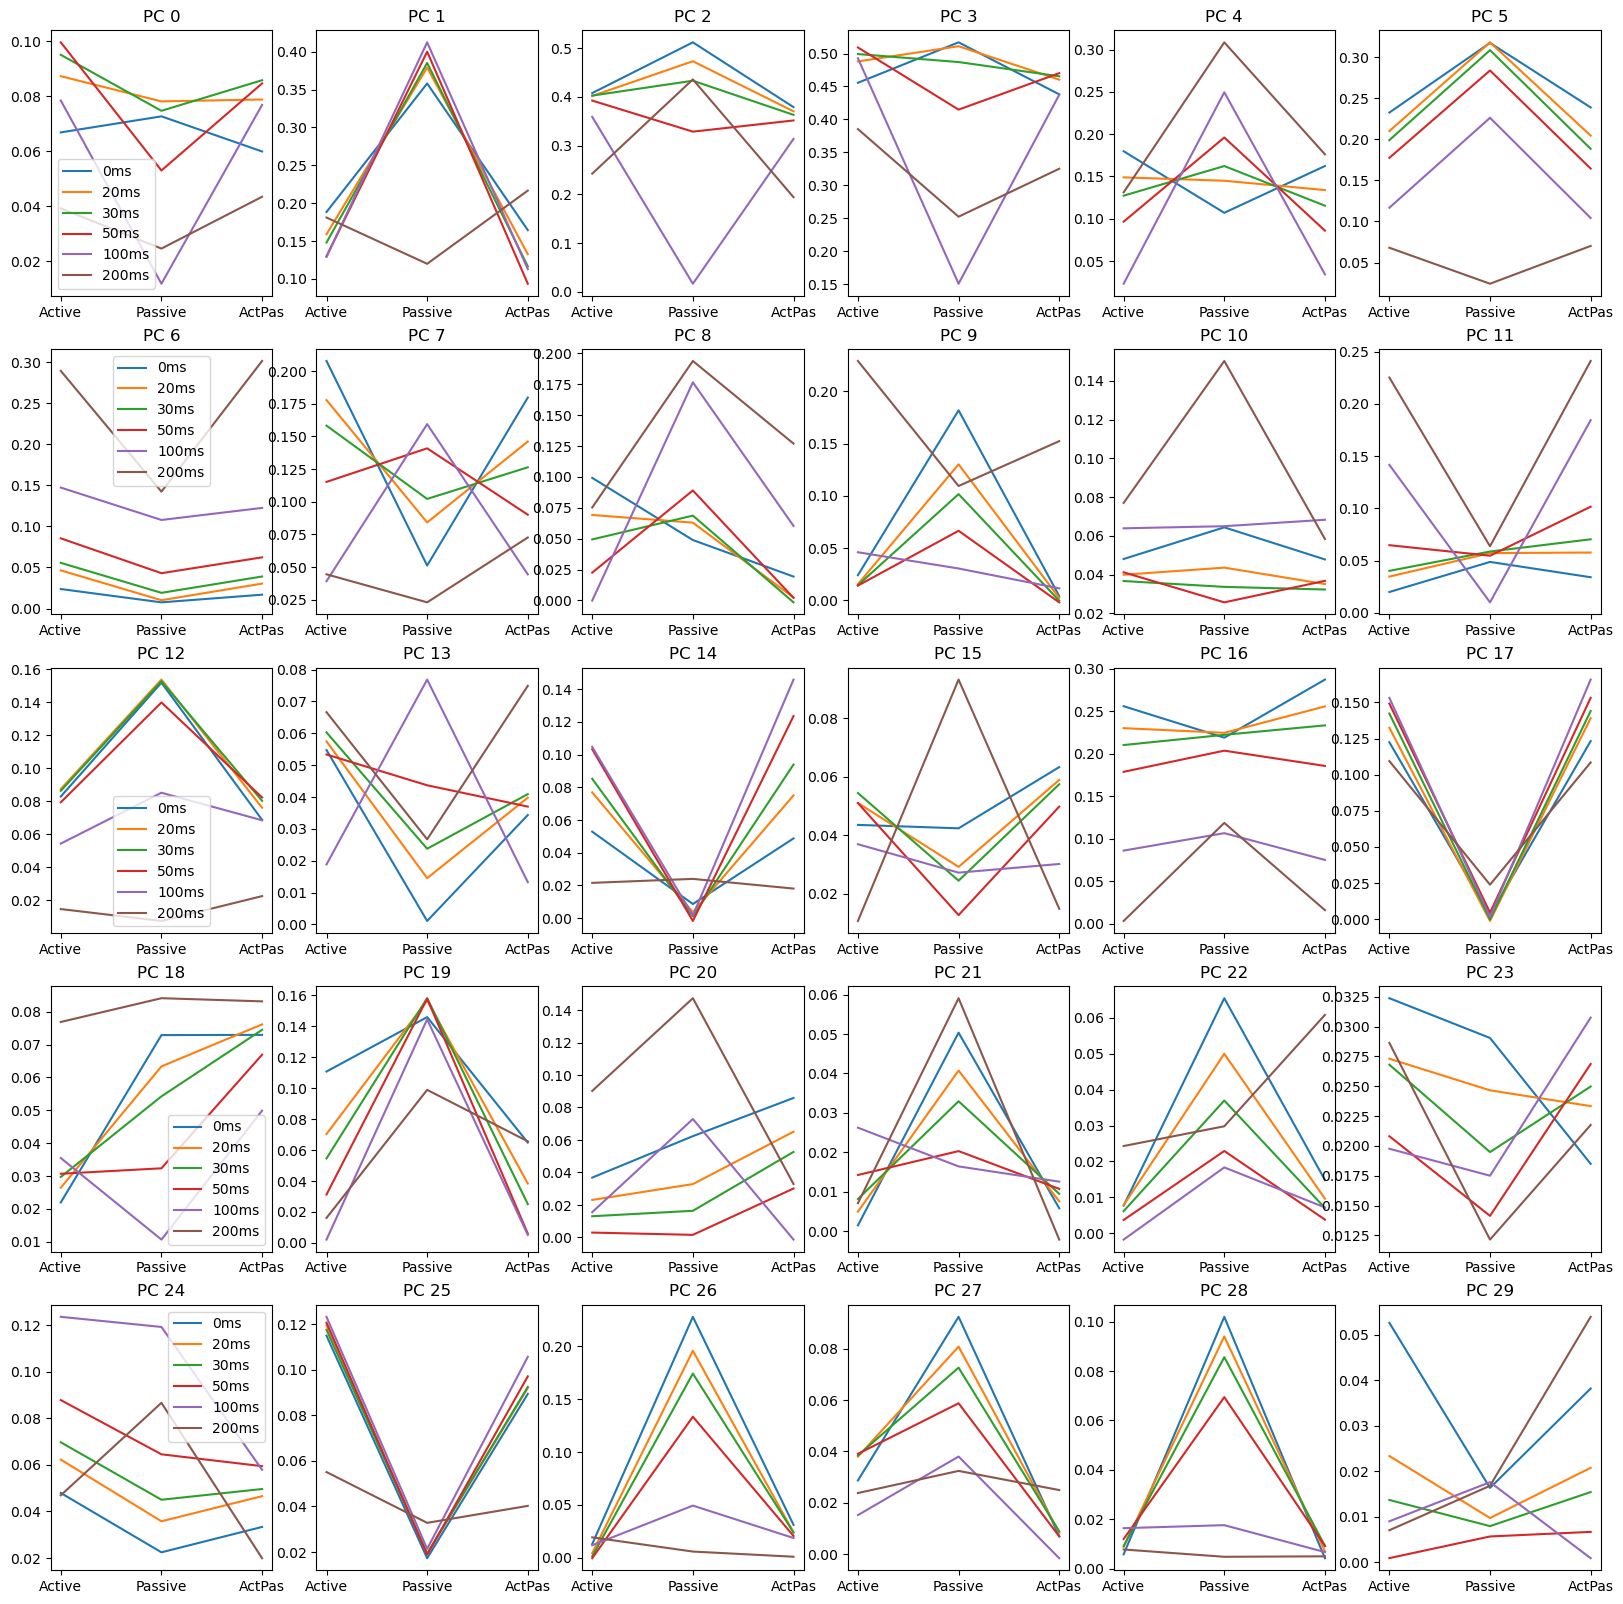

In [13]:
fig, axes = plt.subplots(5, 6, figsize=(20,20))

for pc in range(30):
    for i, time_offset in enumerate(time_offsets):
        row=pc//6
        col = pc % 6
        vals = [offset_data[i][0][pc][0][0], offset_data[i][1][pc][0][0], offset_data[i][2][pc][0][0]]
        axes[row, col].plot(vals, label=f'{time_offset*10}ms')
    axes[row, col].set_xticks([0,1,2], ['Active', 'Passive', 'ActPas'])
    axes[row, col].set_title(f'PC {pc}')
    axes[row, 0].legend()
    #axes[row, col].set_ylim(0, 0.6)

plt.show()

In [36]:
null = [11, 14, 19, 25]
passive = [1, 9, 19, 20, 21, 22, 26, 27, 28, ]

# Interesting graphs:

I like the contrast between the next 2 figures. The offset is positively impacting decoding accuracy for one (6), while reducing accuracy for the other (2).

Regarding the graph of PC2, it appears that time offset mostly impacts the decoding for passive movement. This would hint at 

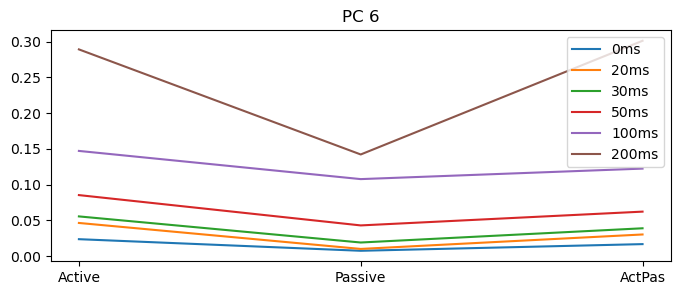

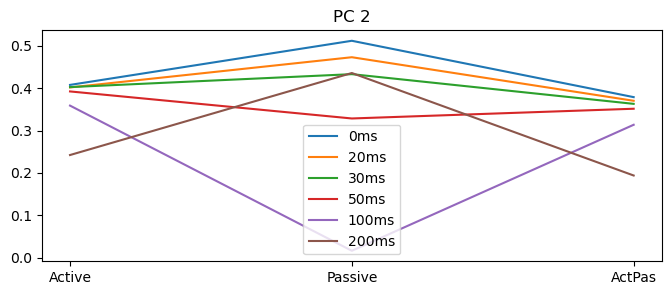

In [21]:
plt.figure(figsize=(8,3))
for i, time_offset in enumerate(time_offsets):
    row=pc//6
    col = pc % 6
    vals = [offset_data[i][0][6][0][0], offset_data[i][1][6][0][0], offset_data[i][2][6][0][0]]
    plt.plot(vals, label=f'{time_offset*10}ms')
plt.xticks([0,1,2], ['Active', 'Passive', 'ActPas'])
plt.title(f'PC 6')
plt.legend()
plt.show()

plt.figure(figsize=(8,3))
for i, time_offset in enumerate(time_offsets):
    row=pc//6
    col = pc % 6
    vals = [offset_data[i][0][2][0][0], offset_data[i][1][2][0][0], offset_data[i][2][2][0][0]]
    plt.plot(vals, label=f'{time_offset*10}ms')
plt.xticks([0,1,2], ['Active', 'Passive', 'ActPas'])
plt.title(f'PC 2')
plt.legend()
plt.show()

# Below PC3 is pure Input-potent. Look at it!

It's doing best on Passive when Time-offset is 0, and it's doing good on both actives when the offset goes up to 50ms. 
<br>
Or is it?
- I was thinking that decoding active trials with a large offset aligns the intention to move with the resulting position without delays. 

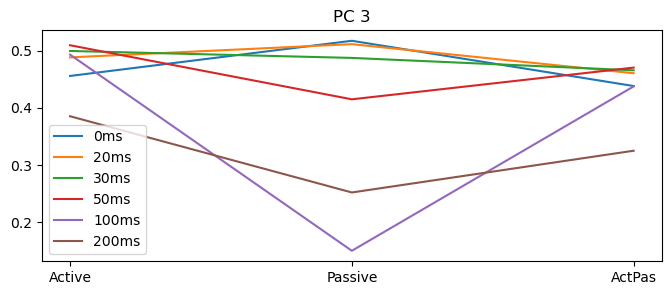

Average Difference between cuetime and active movement onset during passive trials : 215.42ms
Average Difference between cuetime and movement onset during active trials : 239.08ms


In [17]:
plt.figure(figsize=(8,3))
for i, time_offset in enumerate(time_offsets):
    row=pc//6
    col = pc % 6
    vals = [offset_data[i][0][3][0][0], offset_data[i][1][3][0][0], offset_data[i][2][3][0][0]]
    plt.plot(vals, label=f'{time_offset*10}ms')
plt.xticks([0,1,2], ['Active', 'Passive', 'ActPas'])
plt.title(f'PC 3')
plt.legend()
plt.show()

diff = passive_df['idx_activeMovementOnset'] - passive_df['idx_goCueTime']
print(f"Average Difference between cuetime and active movement onset during passive trials : {round(diff.abs().mean()*10, 2)}ms")
diff = active_df['idx_movementOnset'] - active_df['idx_goCueTime']
print(f"Average Difference between cuetime and movement onset during active trials : {round(diff.abs().mean() * 10, 2)}ms")

# PC 17 is always pure input-null

It's very interesting that consistently over all different times I've compiled this data, PC 17 has the same shape. 50 and 100ms time offsets are doing best, which indicates that some delay in brain signals improves the decoding efficiency. Taking into account that the processing of the visual stimulus would ~100ms, this makes sense?

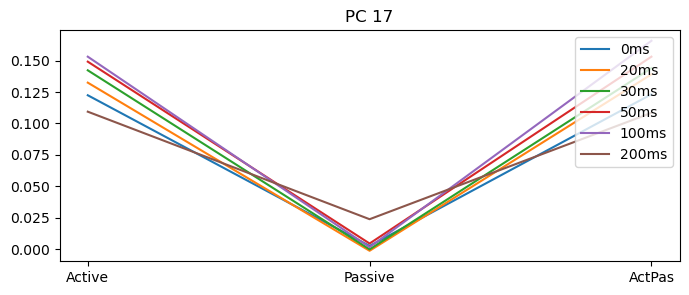

In [28]:
plt.figure(figsize=(8,3))
pc = 17
for i, time_offset in enumerate(time_offsets):
    row=pc//6
    col = pc % 6
    vals = [offset_data[i][0][pc][0][0], offset_data[i][1][pc][0][0], offset_data[i][2][pc][0][0]]
    plt.plot(vals, label=f'{time_offset*10}ms')
plt.xticks([0,1,2], ['Active', 'Passive', 'ActPas'])
plt.title(f'PC {pc}')
plt.legend(loc='upper right')
plt.show()

# I've noticed general decoding efficiency is higher on passive trials.

Spot-checking trials and positions it appears that movement during the passive window is relatively little and consistent compared to the chaotic natural movement.\
Maybe investigate this.

In [47]:
test_df = passive_df.copy()


# Function to calculate variance of a list of coordinates
def calculate_variance(coordinates):
    # Extract x and y coordinates from the list
    x_coordinates = [supercoord[0] for coord in coordinates for supercoord in coord ] 
    y_coordinates = [supercoord[1] for coord in coordinates for supercoord in coord ]
    # Calculate variance for x and y coordinates
    variance_x = pd.Series(x_coordinates).var()
    variance_y = pd.Series(y_coordinates).var()
    return variance_x, variance_y

# Calculate variance for 'pos_window' column
variance_pos_window_x, variance_pos_window_y = calculate_variance(test_df['pos_window'])
# Calculate variance for 'active_pos_window' column
variance_active_pos_window_x, variance_active_pos_window_y = calculate_variance(test_df['active_pos_window'])

# Print the variances
print(f"Variance of 'pos_window' x-coordinate: {variance_pos_window_x}")
print(f"Variance of 'pos_window' x-coordinate: {variance_pos_window_y}")
print(f"Variance of 'active_pos_window' x-coordinate:, {variance_active_pos_window_x}")
print(f"Variance of 'active_pos_window' y-coordinate:, {variance_active_pos_window_y}")

Variance of 'pos_window' x-coordinate: 10.511394765590262
Variance of 'pos_window' x-coordinate: 10.633646823977355
Variance of 'active_pos_window' x-coordinate:, 13.18057384217975
Variance of 'active_pos_window' y-coordinate:, 12.771912103660444


# Variance is a bit higher.


Now what?

To do:
- Decide to use some time-offset.

- Investigate positions & bump/target directions. It appears these are not really working well for session 2 and 3, or at least they are not always visible from the visualised positions.

- Try to decode bumpdirection based on specific groups of PC's?
    - Maybe only decode on specific PC's at first?

In [53]:
print(f"Unique bump directions: {main_df['bumpDir'].unique()}")
print(f"Unique sessions: {main_df['session'].unique()}")
print(f"Unique sessions: {active_df['session'].unique()}")

Unique bump directions: [ 90.   0. 180. 270.  nan  45. 315. 135. 225.]
Unique sessions: [0 1 2 3]
Unique sessions: [2 3]


# Let's decode every 